# Q-Learning with Tables and Neural Networks

https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

## Notes

### Q-Learning algorithms

Q-Learning attempts to learn the value of being in a given state, and taking a specific action there - unlike policy gradient methods, which attempt to learn functions which directly map an observation to an action.

While both approaches ultimately allow us to take intelligent actions given a situation, the means of getting to that action differ significantly.

Instead of starting with a complex and unwieldy deep neural network, we will begin by implementing a simple lookup-table version of the algorithm, and then show how to implement a neural-network equivalent using Tensorflow. 

In it’s simplest implementation, Q-Learning is a table of values for every state (row) and action (column) possible in the environment. Within each cell of the table, we learn a value for how good it is to take a given action within a given state.

### Belman's Equation for Q-Learning

We make updates to our Q-table using something called the Bellman equation, which states that the expected long-term reward for a given action is equal to the immediate reward from the current action combined with the expected reward from the best future action taken at the following state. In this way, we reuse our own Q-table when estimating how to update our table for future actions! 

In equation form, the rule looks like this:

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0fe1ed37fa6eb19e26b55529c42f9d65b8f14a35)

This says that the Q-value for a given state (s) and action (a) should represent the current reward (r) plus the maximum discounted (γ) future reward expected according to our own table for the next state (s’) we would end up in. The discount variable allows us to decide how important the possible future rewards are compared to the present reward. 

If you think of the Q algorithm in the context of gradient descent, then `r + γ(max(Q(s’,a’))` is what we would like to approach, but we know that it is a noisy estimate of the true Q value for that given region. So instead of directly updating toward it, we take a small step in the direction that will make the Q value closer to the desired one.

By updating in this way, the table slowly begins to obtain accurate measures of the expected future reward for a given action in a given state.

### The FrozenLake Environment

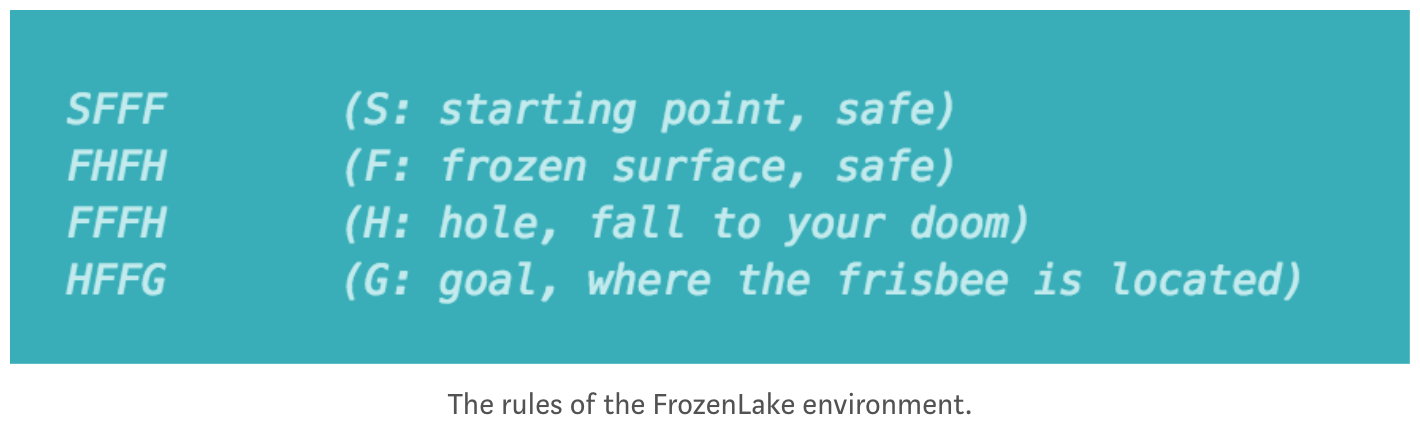

https://gym.openai.com/envs/FrozenLake-v0/

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction (i.e. due to wind). The agent is rewarded for finding a walkable path to a goal tile.

Perfect performance every time is impossible, but learning to avoid the holes and reach the goal are certainly still doable. The reward at every step is 0, except for entering the goal, which provides a reward of 1. Thus, we will need an algorithm that learns long-term expected rewards. This is exactly what Q-Learning is designed to provide.



#### Matrix Implementation

In the case of the FrozenLake environment, we have 16 possible states (one for each block), and 4 possible actions (the four directions of movement), giving us a 16x4 table of Q-values. 

We start by initializing the table to be uniform (all zeros), and then as we observe the rewards we obtain for various actions, we update the table accordingly.

#### Neural Network Implementation

Tables are great, but they don’t really scale. While it is easy to have a 16x4 table for a simple grid world, the number of possible states in any modern game or real-world environment is nearly infinitely larger. For most interesting problems, tables simply don’t work.

We instead need some way to take a description of our state, and produce Q-values for actions without a table: that is where neural networks come in. By acting as a function approximator, we can take any number of possible states that can be represented as a vector and learn to map them to Q-values.

In the case of the FrozenLake example, we will be using a one-layer network which takes the state encoded in a one-hot vector (1x16), and produces a vector of 4 Q-values, one for each action.

Such a simple network acts kind of like a glorified table, with the network weights serving as the old cells. The key difference is that we can easily expand the Tensorflow network with added layers, activation functions, and different input types, whereas all that is impossible with a regular table.

The method of updating is a little different as well. Instead of directly updating our table, with a network we will be using backpropagation and a loss function. Our loss function will be sum-of-squares loss, where the difference between the current predicted Q-values, and the “target” value is computed and the gradients passed through the network. In this case, our Q-target for the chosen action is the equivalent to the Q-value computed in Bellman's equation above.

Eq2. Loss = ∑(Q-target - Q)²

While the network learns to solve the FrozenLake problem, it turns out it doesn’t do so quite as efficiently as the Q-Table. While neural networks allow for greater flexibility, they do so at the cost of stability when it comes to Q-Learning.

There are a number of possible extensions to our simple Q-Network which allow for greater performance and more robust learning. Two tricks in particular are referred to as Experience Replay and Freezing Target Networks. Those improvements and other tweaks were the key to getting Atari-playing Deep Q-Networks.

For more info on the theory behind Q-Learning, see this great post by Tambet Matiisen: http://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/.

## Coding

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
tf.reset_default_graph()

env = gym.make('FrozenLake-v0')
print(env.action_space)
print(env.observation_space)
print(env.reward_range)
print(env.reset())
print(env.action_space.sample())

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Discrete(4)
Discrete(16)
(-inf, inf)
0
0


### Implement Q-Table learning algorithm¶

#### Implement Training

In [2]:
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n, env.action_space.n])

# Set learning parameters
lr = 0.8
y = .99

max_time_to_goal = 99
num_episodes = 4000

# create lists to contain total rewards
table_rList = []
table_jList = []
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0

    # The Q-Table learning algorithm
    while j < max_time_to_goal:
        j+=1
        # Choose an action by greedily (with noise) picking from Q table
        # Adding noise as a means of encouraging exploration
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))

        # Get new state and reward from environment
        s1, r, d, info = env.step(a)

        # Update Q-Table with new knowledge
        Q[s,a] += lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break

    table_jList.append(j)
    table_rList.append(rAll)


Score over time: 0.505


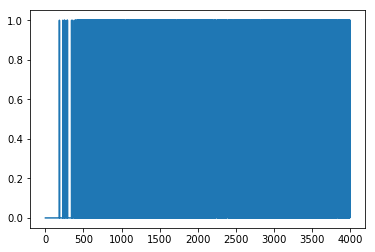

First 20 attempts


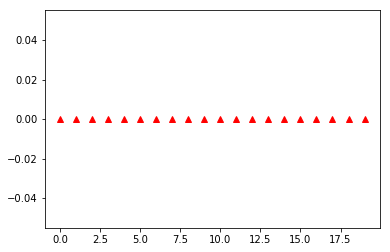

Last 20 attempts


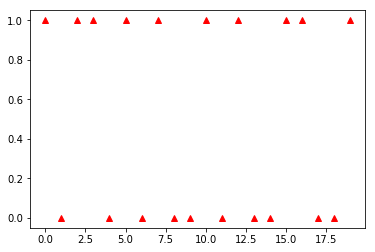

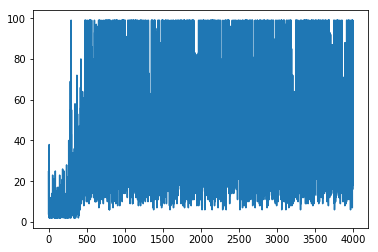

[[  5.10510649e-01   8.37485328e-03   5.73688572e-03   7.23148942e-03]
 [  1.09772626e-03   9.72777202e-05   1.11979071e-03   3.13835664e-01]
 [  3.08532337e-01   1.51824655e-03   4.67135205e-03   5.04048818e-03]
 [  1.06579904e-03   3.45626981e-03   1.19185758e-03   6.23728905e-03]
 [  5.18656599e-01   1.36398136e-03   3.45374179e-04   3.30022886e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  6.12598640e-05   8.97136345e-06   5.66065823e-02   9.04723004e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.35630640e-03   1.27593158e-03   1.23644604e-04   6.30208771e-01]
 [  0.00000000e+00   7.99932188e-01   7.60742616e-04   0.00000000e+00]
 [  2.76100595e-01   1.08699608e-03   1.22231385e-03   1.30488971e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.94987479e-03   2.04277104e-04   4.72962343e-01   0.00000000e+00]
 [  0.

In [3]:
print("Score over time: " +  str(sum(table_rList)/num_episodes))

plt.plot(table_rList)
plt.show()
plt.close()

print("First 20 attempts")
plt.plot(range(20), table_rList[:20], 'r^')
plt.show()
plt.close()

print("Last 20 attempts")
plt.plot(range(20), table_rList[-20:], 'r^')
plt.show()
plt.close()


plt.plot(table_jList)
plt.show()
plt.close()


# print("Final Q-Table Values")
print(Q)

#### Test the training results

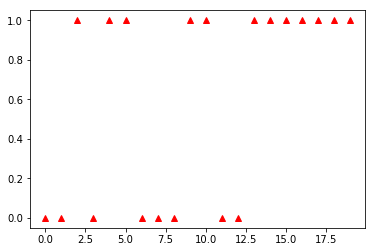

In [4]:
# Testing the results
test_res = []
max_time_to_goal = 500

for i in range(20):
    s = env.reset()

    rAll = 0
    d = False
    j = 0

    while j < max_time_to_goal:
        j+=1
        # Choose an action by greedily picking from Q table for the current state
        a = np.argmax(Q[s,:])

        # Get new state and reward from environment
        s1, r, d, info = env.step(a)

        rAll += r
        s = s1
        if d == True:
            break

    test_res.append(rAll)

    
plt.plot(range(len(test_res)), test_res, 'r^')
plt.show()
plt.close()


### Implementing Neural network

In [5]:
# Tensorflow "Hello world"
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

sess.close()

b'Hello, TensorFlow!'


In [6]:
# https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
# https://blog.jakuba.net/2017/05/30/tensorflow-visualization.html
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

#### Implementing the Network

In [7]:
try:
    test_sess.close()
    tf.reset_default_graph()
except:
    pass
finally:
    test_sess  = tf.Session()
testW = tf.Variable(tf.random_uniform([env.observation_space.n, env.action_space.n], 0, 0.01))

test_sess.run(tf.global_variables_initializer())
print(test_sess.run(testW))
print(test_sess.run(testW) == test_sess.run(testW))

test_sess.close()

[[ 0.00323574  0.00272117  0.00049154  0.00036215]
 [ 0.00053308  0.00026835  0.00559585  0.00806501]
 [ 0.00826553  0.00095417  0.00773576  0.00390211]
 [ 0.00209084  0.00113531  0.00146883  0.00431109]
 [ 0.00743519  0.00310312  0.00071518  0.00624152]
 [ 0.0068242   0.00496104  0.00834858  0.00787078]
 [ 0.00476236  0.00853717  0.00805244  0.00106734]
 [ 0.00512776  0.00401169  0.00482826  0.00030218]
 [ 0.00586783  0.00932443  0.00795715  0.00383247]
 [ 0.00459356  0.0020648   0.00612802  0.00661171]
 [ 0.00295511  0.00441655  0.00918686  0.00460189]
 [ 0.00371568  0.00266358  0.00724646  0.00480809]
 [ 0.00878282  0.00493386  0.00779536  0.00166399]
 [ 0.00632857  0.00331365  0.0041422   0.00326167]
 [ 0.00364894  0.00694289  0.0061717   0.00570443]
 [ 0.0031507   0.00743761  0.00018054  0.00951385]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  

In [8]:
try:
    sess.close()
    tf.reset_default_graph()
except:
    pass
finally:
    sess = tf.Session()

# These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1, env.observation_space.n], dtype=tf.float32, name="Current-State-Input")
# Initialize the weights of the neural links between the input nodes and each action node
W = tf.Variable(tf.random_uniform([env.observation_space.n, env.action_space.n], 0, 0.01), name="Input-to-Action-Weights")
# Caliculating the output nodes for a given input
Qout = tf.matmul(inputs1, W, name="Predicted-Actions-Quality")
# Each predicted action is the maximum output node for the given input
predict = tf.argmax(Qout, 1, name="Predicted-Best-Action")

# Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1, env.action_space.n], dtype=tf.float32, name="Actual-Action-Quality")
# Get the square difference for each cell and sum over all cells
loss = tf.reduce_sum(tf.square(nextQ - Qout), name="Current-Loss")
# Initialize a gradient descent trainer which will change the weights to reach a stable point
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1, name="Optimize-Weights-Gradient-Descent")
# Define the calculation goal - find a minimum loss
updateModel = trainer.minimize(loss)

print("Variables that will be trained:", tf.trainable_variables()[0])
show_graph(tf.get_default_graph())


Variables that will be trained: <tf.Variable 'Input-to-Action-Weights:0' shape=(16, 4) dtype=float32_ref>


In [9]:
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000

# create lists to contain total rewards and steps per episode
jList = []
rList = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        # The Q-Network
        while j < 99:
            j+=1
            # Choose an action by greedily (with e chance of random action) from the Q-network
            # sess.run Runs operations and evaluates tensors in fetches.
            a, allQ = sess.run([predict, Qout], feed_dict={inputs1: np.identity(16)[s:s+1]})
            
            chosen_action = env.action_space.sample() if np.random.rand(1) < e else a[0]

            # Get new state and reward from environment
            s1,r,d,_ = env.step(chosen_action)

            # Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout, feed_dict={inputs1: np.identity(16)[s1:s1+1]})

            # Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, chosen_action] = r + y*maxQ1

            # Train our network using target and predicted Q values
            # last_W1 = W1
            _,W1 = sess.run([updateModel, W],feed_dict={inputs1: np.identity(16)[s:s+1],
                                                        nextQ: targetQ})
            # print(last_W1 == W1)
            rAll += r
            s = s1
            if d == True:
                # Reduce chance of random action as we train the model (per episode).
                e = 1. / ((i / 50) + 10)
                break
        jList.append(j)
        rList.append(rAll)

print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.418%


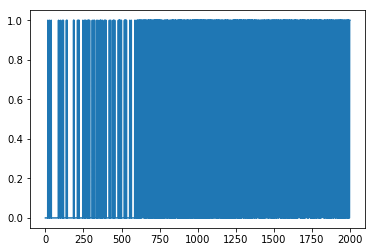

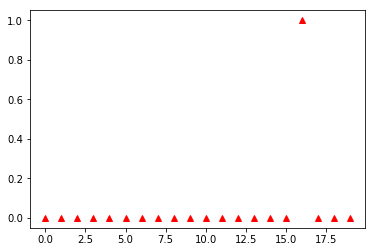

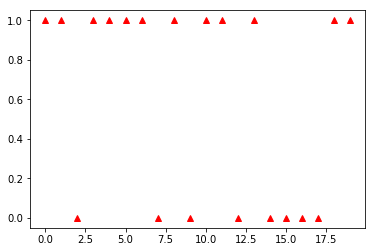

We can see that the network beings to consistly reach the goal around the 750 episode mark.
It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.


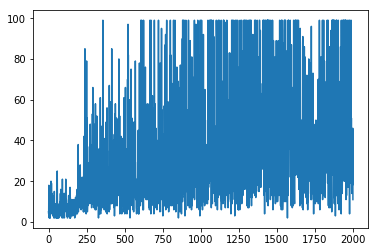

In [10]:
plt.plot(rList)
plt.show()
plt.close()

plt.plot(range(len(rList[:20])), rList[:20], 'r^')
plt.show()
plt.close()

plt.plot(range(len(rList[-20:])), rList[-20:], 'r^')
plt.show()
plt.close()

print("We can see that the network beings to consistly reach the goal around the 750 episode mark.\n"
"It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.")
plt.plot(jList)
plt.show()
plt.close()

# Bandit Problems

Reinforcement learning provides the capacity for us not only to teach an artificial agent how to act, but to allow it to learn through it’s own interactions with an environment.

Learning how to build these agents requires a bit of a change in thinking for anyone used to working in a supervised learning setting though. Gone is the ability to simply get the algorithm to pair certain stimuli with certain responses.

RL algorithms must enable the agent to learn the correct pairings itself through the use of observations, rewards, and actions. Since there is no longer a “True” correct action for an agent to take in any given circumstance that we can just tell it, things get a little tricky.

## Notes

### n-armed Bandit

The simplest reinforcement learning problem is the n-armed bandit.

Essentially, there are n-many slot machines, each with a different fixed payout probability. The goal is to discover the machine with the best payout, and maximize the returned reward by always choosing it.

We are going to make it even simpler, by only having two possible slot machines to choose between. In fact, this problem is so simple that it is more of a precursor to real RL problems than one itself.

Let me explain. Typical aspects of a task that make it an RL problem are the following:
1. Different actions yield different rewards. For example, when looking for treasure in a maze, going left may lead to the treasure, whereas going right may lead to a pit of snakes.
2. Rewards are delayed over time. This just means that even if going left in the above example is the right things to do, we may not know it till later in the maze.
3. Reward for an action is conditional on the state of the environment. Continuing the maze example, going left may be ideal at a certain fork in the path, but not at others.

The n-armed bandit is a nice starting place because we don’t have to worry about aspects #2 and 3. All we need to focus on is learning which rewards we get for each of the possible actions, and ensuring we chose the optimal ones.

In the context of RL lingo, this is called learning a policy.

#### History
http://banditalgs.com/2016/09/04/bandits-a-new-beginning/

Bandit problems were introduced by William R. Thompson (one of our heroes, whose name we will see popping up again soon) in a paper in 1933 for the so-called Bayesian setting (that we will also talk about later). Thompson was interested in medical trials and the cruelty of running a trial “blindly”, without adapting the treatment allocations on the fly as the drug appears more or less effective.


Clinical trials is thus one of the first intended applications. But why would anyone call problems like optimizing drug allocation a “bandit-problem”? The name comes from the 1950s when Frederick Mosteller and Robert Bush decided to study animal learning and ran trials on mice and then on humans. The mice faced the dilemma of choosing to go left or right, after starting in the bottom of a T-shaped maze, not knowing each time at which end they will find food. 

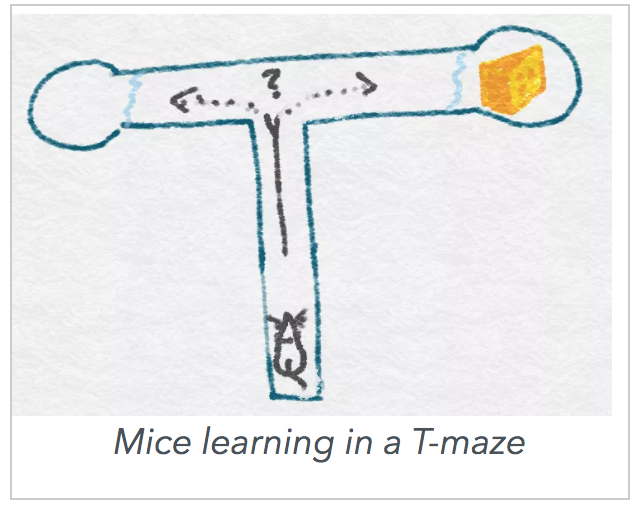

To study a similar learning setting in humans, a “two-armed bandit” machine was commissioned where humans could choose to pull either the left or the right arm of the machine, each giving a random payoff with the distribution of payoffs for each arm unknown to the human player. The machine was called a “two-armed bandit” in homage to the one-armed bandit, an old-fashioned name for a lever operated slot machine (“bandit” because they steal your money!).

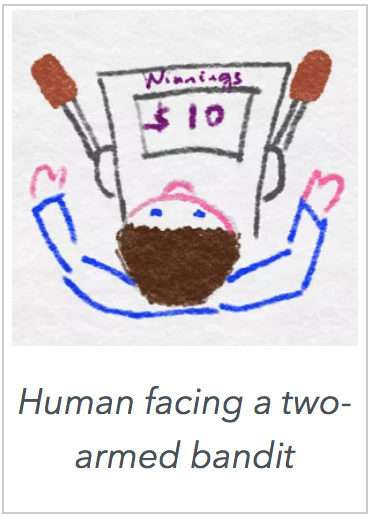

#### Problem Description
Now, imagine that you are playing on this two-armed bandit machine and you already pulled each lever 5 times, resulting in the following payoffs:

Left arm:    0, 10, 0, 0, 10
Right arm: 10,  0, 0, 0,  0

The left arm appears to be doing a little better: The average payoff for this arm is 4 (say) dollars per round, while that of the right arm is only 2 dollars per round. Let’s say, you have 20 more trials (pulls) altogether. How would you pull the arms in the remaining trials? Will you keep pulling the left arm, ignoring the right (owing to its initial success), or would you pull the right arm a few more times, thinking that maybe the initial poorer average payoff is due to “bad luck” only?

This illustrates the interest in bandit problems: They capture the fundamental dilemma a learner faces when choosing between uncertain options. Should one explore an option that looks inferior or should one exploit one’s knowledge and just go with the currently best looking option? How to maintain the balance between exploration and exploitation is at the heart of bandit problems.

#### Modeling Bandit Problems
There are many real-world problems where a learner repeatedly chooses between options with uncertain payoffs with the sole goal of maximizing the total gain over some period of time. However, the world is a messy place. To gain some principled understanding of the learner’s problem, we will often make extra modelling assumptions to restrict how the rewards are generated. To be able to talk about these assumptions, we need a more formal language. In this formal language we are talking about the learner as someone (or something) that interacts with an environment as shown in the figure below.

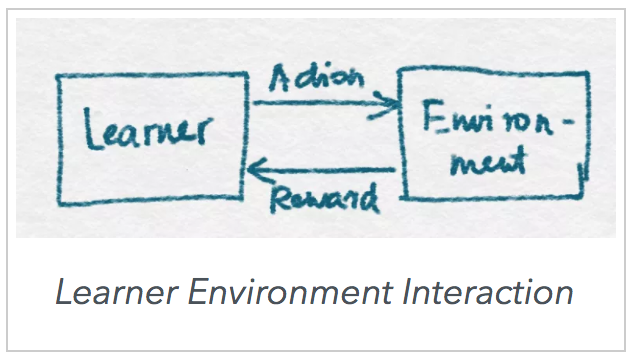

On the figure the learner is a represented by a box on the left, the environment is represent by a box on the right. They are interconnected by two arrows connecting the two boxes. These arrows represent the interaction between the learner and the environment. What the figure fails to capture is that the interaction happens in a sequential fashion over a number of discrete rounds. In particular, the specification starts with the following interaction protocol:

For rounds t=1,2,…,n:
1. Learner chooses an action A_t from a set A of available actions. The chosen action is sent to the environment;
2. The environment generates a response in the form of a real-valued reward X_t∈ℝ, which is sent back to the learner.

The goal of the learner is to maximize the sum of rewards that it receives, ∑_n^(t=1)X_t.

#### What is being learnt
When in step 2 we say that the reward is sent back to the learner, we mean that the learner gets to know this number and can thus use it in the future rounds when it needs to decide which action to take. Thus, in step 1 of round t, the learner’s decision is based on the history of interaction up to the end of round t−1, i.e., on H_(t−1)=(A_1,X_1,…,A_(t−1),X_(t−1)).

Our goal, is to equip the learner with a learning algorithm to maximize its reward. Most of the time, the word “algorithm” will not be taken too seriously in the sense that a “learning algorithm” will be viewed as a mapping of possible histories to actions (possibly randomized). Nevertheless, throughout the course we will keep an eye on discussing whether such maps can be efficiently implemented on computers (justifying the name “algorithms”).

#### Evaluating the learner / learning algorithm
The next question to discuss is how to evaluate a learner (to simplify language, we identify learners and learning algorithms)? One idea is to measure learning speed by what is called the regret. The regret of a learner acting in an environment is relative to some action. We will start with a very informal definition (and hope you forgive us). The reason is that there a number of related definitions – all quite similar – and we do not want to be bogged down with the details in this introductory post.

The regret of learner relative to action a =
Total reward gained when a is used for all n rounds –
Total reward gained by the specific learner in n rounds according to its chosen actions.

We often calculate the worst-case regret over the possible actions aa, though in stochastic environments, we may first take expectations for each action and then calculate the worst-case over the actions (later we should come back to discussing the difference between taking the expectation first and then the maximum, versus taking the maximum first and then the expectation). For a fixed environment, the worst-case regret is just a shift and a sign change of the total reward: Maximizing reward is the same as minimizing regret.

A good learner achieves sublinear worst-case regret: That is, if Rn is the regret after n rounds of interaction of a learner, R_n=o(n). In other words, the average per round regret, Rn/n converges to zero as n→∞. Of major interest will be to see the rate of growth of regret for various classes of environments, as well as for various algorithms, and in particular, seeing how small the regret can be over some class of environment and what algorithms can achieve such regret lower bounds.

The astute reader may notice that regret compares payoffs of fixed actions to the total payoff of the learner: In particular, in a non-stationary environment, a learner that can change what action it uses over time may achieve negative worst-case regret! In other words, the assumption that the world is stationary (i.e., there are no seasonality or other patterns in the environment, there is no payoff drift, etc.) is built into the above simple concept of regret.

The notion of regret can and has been extended to make it more meaningful in non-stationary environments, but as a start, we should be content with the assumption of stationarity. Another point of discussion is whether in designing a learning algorithm we can use the knowledge of the time horizon n or not.  In some learning settings assuming this is perfectly fine (say, businesses can have natural business cycles, say, weeks, months, etc.), but sometimes assuming the knowledge of the time horizon is unnatural. In those cases we will be interested in algorithms that work well in lack of the knowledge of the time horizon, in other words, also known as anytime algorithms. As we will see, sometimes the knowledge of time horizon will make a difference when it comes to designing learning algorithms, though usually we find that the difference will be small.

Let’s say we are fine with stationarity. Still, why should one use (worst-case) regret as opposed to simply resorting to comparing learners by the total reward they collected, especially since we said that minimizing the regret is the same as maximizing total reward? Why complicate matters with talking about regret then?

First, regret facilitates comparisons across environments by doing a bit of normalization: One can shift rewards by an arbitrary constant amount in some environment and the regret does not change, whereas total reward would be impacted by this change (note that scale is still an issue: multiplying the rewards by a positive constant number, the regret also gets multiplied, so usually we assume some fixed scale, or we need to normalize regret with the scale of rewards).

More important however is that regret is well aligned with the intuition that learning should be easy in environments where either
1. all actions pay similar amounts (all learners do well in such environments and all of them will have low regret).
2. some actions pay significantly more than others (because in such environments it is easy to find the high-paying action or actions, so many learners will have small regret).

As a result, the worst-case regret over various classes of environment is a meaningful quantity, as opposed to worst-case total reward which is vacuous. Generally, regret allows one to study learning in worst-case settings. Whether this leads to conservative behavior is another interesting point for further discussion (and is an active topic of research).

### Restrictions of the Bandit Model
With this, let me turn to discussing the typical restrictions on the bandit environments. A particularly simple, yet appealing and rich problem setting is that of stochastic, stationary bandits. In this case the environment is restricted to generate the reward in response to each action from a distribution that is specific to that action, and independently of the previous action choices (of the possibly randomizing learner) and rewards. Sometimes, this is also called “stochastic i.i.d.” bandits since for a given action, any reward for that action is independent of all the other rewards of the same action and they are all generated from identical distributions (that is, there is one distribution per action). Since “stochastic, stationary” and “stochastic i.i.d.” are a bit too long, in the future, we will just refer to this setting as that of “stochastic bandits“. This is the problem setting that we will start discussing next week.

For some applications the assumption that the rewards are generated in a stochastic and stationary way may be too restrictive. In particular, stochastic assumptions can be hard to justify in the real-world: The world, for most of what we know about it, is deterministic, if it is hard to predict and often chaotic looking. Of course, stochasticity has been enormously successful to explain mass phenomenon and patterns in data and for some this may be sufficient reason to keep it as the modeling assumption. But what if the stochastic assumptions fail to hold? What if they are violated for a single round? Or just for one action, at some rounds? Will all our results become suddenly vacuous? Or will the algorithms developed be robust to smaller or larger deviations from the modeling assumptions?

One approach, which is admittedly quite extreme, is to drop all the assumptions on how rewards are assigned to arms. More precisely, some minimal assumptions are kept, like that the rewards lie in a bounded interval, or that the reward assignment is done before the interaction begins, or simultaneously with the choice of the learner’s action. In any case, if these are the only assumptions, we get what is called the setting of adversarial bandits. Can we still say meaningful things about the various algorithms? Can learning algorithms achieve nontrivial results? Can their regret be sublinear?

It turns out, that, perhaps surprisingly, this is possible. At a second thought though this may not be that surprising: After all, sublinear regret requires only that the learner uses the single best action (best in hindsight) for most of the time, but the learner can still use any other actions for a smaller (and vanishing) fraction of time. What saves learners then is that the identity of the  action with the highest total payoff in hindsight cannot change too abruptly and too often as averages cannot be changed too much as long as the summands in the average are bounded.

### Stochastic Bandits
http://banditalgs.com/2016/09/04/stochastic-bandits-warm-up/

### Policy Gradients

We are going to be using a method called policy gradients, where our simple neural network learns a policy for picking actions by adjusting it’s weights through gradient descent using feedback from the environment.

There is another approach to reinforcement learning where agents learn value functions. In those approaches, instead of learning the optimal action in a given state, the agent learns to predict how good a given state or action will be for the agent to be in. Both approaches allow agents to learn good behavior, but the policy gradient approach is a little more direct.

In the case of our bandit, we don’t need to condition these outputs on any state. As such, our network will consist of just a set of weights, with each corresponding to each of the possible arms to pull in the bandit, and will represent how good our agent thinks it is to pull each arm. If we initialize these weights to 1, then our agent will be somewhat optimistic about each arm’s potential reward.

The simplest way to think of a Policy gradient network is one which produces explicit outputs.


To update our network, we will simply try an arm with an e-greedy policy. This means that most of the time our agent will choose the action that corresponds to the largest expected value, but occasionally, with e probability, it will choose randomly. In this way, the agent can try out each of the different arms to continue to learn more about them.

Once our agent has taken an action, it then receives a reward of either 1 or -1. With this reward, we can then make an update to our network using the policy loss equation:

Loss = -log(π)*A

- A is advantage, and is an essential aspect of all reinforcement learning algorithms. Intuitively it corresponds to how much better an action was than some baseline. In future algorithms, we will develop more complex baselines to compare our rewards to, but for now we will assume that the baseline is 0, and it can be thought of as simply the reward we received for each action.
- π is the policy. In this case, it corresponds to the chosen action’s weight.

Intuitively, this loss function allows us to increase the weight for actions that yielded a positive reward, and decrease them for actions that yielded a negative reward. In this way the agent will be more or less likely to pick that action in the future. By taking actions, getting rewards, and updating our network in this circular manner, we will quickly converge to an agent that can solve our problem!

### Research papers
#### Stochastic Multi-Armed-Bandit Problem with Non-stationary Rewards
- https://papers.nips.cc/paper/5378-stochastic-multi-armed-bandit-problem-with-non-stationary-rewards.pdf
- https://arxiv.org/pdf/1405.3316.pdf

#### Regret Analysis of Stochastic and Nonstochastic Multi-armed Bandit Problems
- https://arxiv.org/pdf/1204.5721v2.pdf

## Code

### Setup

In [11]:
import tensorflow as tf
import numpy as np

### Bandits
Here we define our bandits. For this example we are using a four-armed bandit. The pullBandit function generates a random number from a normal distribution with a mean of 0. The lower the bandit number, the more likely a positive reward will be returned. We want our agent to learn to always choose the bandit that will give that positive reward.

In [12]:
# List out our bandits. Currently bandit 4 (index#3) is set to most often provide a positive reward.
bandits = [0.2, 0, -0.2, -5]
num_bandits = len(bandits)
def pullBandit(bandit):
    #G et a random number.
    result = np.random.randn(1)
    if result > bandit:
        #return a positive reward.
        return 1
    else:
        #return a negative reward.
        return -1

### Epsilon Greedy Agent
The code below established our simple neural agent. It consists of a set of values for each of the bandits. Each value is an estimate of the value of the return from choosing the bandit. We use a policy gradient method to update the agent by moving the value for the selected action toward the recieved reward.

In [13]:
tf.reset_default_graph()

#These two lines established the feed-forward part of the network. This does the actual choosing.
weights = tf.Variable(tf.ones([num_bandits]), name="bandit-weights")
chosen_action = tf.argmax(weights,0, name="chosen-action")

#The next six lines establish the training proceedure. We feed the reward and chosen action into the network
#to compute the loss, and use it to update the network.
reward_holder = tf.placeholder(shape=[1], dtype=tf.float32, name="reward")
action_holder = tf.placeholder(shape=[1], dtype=tf.int32, name="action")
responsible_weight = tf.slice(weights, action_holder, [1], name="policy-pi")
loss = -(tf.log(responsible_weight) * reward_holder)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001, name="loss-optimizer")
update = optimizer.minimize(loss)

print("Variables that will be trained:", tf.trainable_variables()[0])
show_graph(tf.get_default_graph())

Variables that will be trained: <tf.Variable 'bandit-weights:0' shape=(4,) dtype=float32_ref>


#### Training the Agent
We will train our agent by taking actions in our environment, and recieving rewards. Using the rewards and actions, we can know how to properly update our network in order to more often choose actions that will yield the highest rewards over time.

In [14]:
total_episodes = 1000  # Set total number of episodes to train agent on.
total_reward = np.zeros(num_bandits) # Set scoreboard for bandits to 0.
e = 0.1 # Set the chance of taking a random action.

init = tf.global_variables_initializer()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        
        #Choose either a random action or one from our network.
        if np.random.rand(1) < e:
            action = np.random.randint(num_bandits)
        else:
            action = sess.run(chosen_action)
        
        reward = pullBandit(bandits[action])  # Get our reward from picking one of the bandits.
        
        # Update the network.
        _,resp,ww = sess.run([update,responsible_weight,weights],
                             feed_dict={reward_holder:[reward],action_holder:[action]})
        
        #Update our running tally of scores.
        total_reward[action] += reward
        if i % 50 == 0:
            print("Running reward for the " + str(num_bandits) + " bandits: " + str(total_reward))
        i+=1

print("The agent thinks bandit " + str(np.argmax(ww)+1) + " is the most promising....")
if np.argmax(ww) == np.argmax(-np.array(bandits)):
    print("...and it was right!")
else:
    print("...and it was wrong!")


Running reward for the 4 bandits: [ 1.  0.  0.  0.]
Running reward for the 4 bandits: [ -1.  -1.  17.   4.]
Running reward for the 4 bandits: [ -1.   0.  22.   4.]
Running reward for the 4 bandits: [  0.   1.  44.   4.]
Running reward for the 4 bandits: [  1.   0.  58.   4.]
Running reward for the 4 bandits: [ -1.   0.  73.   5.]
Running reward for the 4 bandits: [ -3.  -2.  76.   6.]
Running reward for the 4 bandits: [ -3.  -2.  89.   7.]
Running reward for the 4 bandits: [ -4.  -2.  91.  10.]
Running reward for the 4 bandits: [  -4.   -3.  101.   13.]
Running reward for the 4 bandits: [  -4.   -3.  116.   14.]
Running reward for the 4 bandits: [  -4.   -4.  126.   17.]
Running reward for the 4 bandits: [  -4.   -4.  128.   17.]
Running reward for the 4 bandits: [  -7.   -4.  139.   17.]
Running reward for the 4 bandits: [  -7.   -4.  140.   20.]
Running reward for the 4 bandits: [  -6.   -4.  153.   20.]
Running reward for the 4 bandits: [  -9.   -4.  166.   20.]
Running reward for t

### UCB Agent
https://github.com/bgalbraith/bandits/blob/master/bandits/policy.py

In [15]:
tf.reset_default_graph()

#These two lines established the feed-forward part of the network. This does the actual choosing.
weights = tf.Variable(tf.ones([num_bandits]), name="bandit-weights")
t = tf.placeholder(shape=[1], dtype=tf.float32, name="timestep")
action_attempts = tf.placeholder(shape=[num_bandits], dtype=tf.float32, name="action-attempts")
exploration = tf.log(t) / action_attempts
tf.where(tf.is_nan(exploration), tf.zeros_like(exploration), exploration)
c = tf.placeholder(shape=[1], dtype=tf.float32, name="confidence")
chosen_action = tf.argmax(weights + (exploration ** 1 / c), 0, name="chosen-action")

#The next six lines establish the training proceedure. We feed the reward and chosen action into the network
#to compute the loss, and use it to update the network.
reward_holder = tf.placeholder(shape=[1], dtype=tf.float32, name="reward")
action_holder = tf.placeholder(shape=[1], dtype=tf.int32, name="action")
responsible_weight = tf.slice(weights, action_holder, [1], name="policy-pi")
loss = -(tf.log(responsible_weight) * reward_holder)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1, name="loss-optimizer")
update = optimizer.minimize(loss)

print("Variables that will be trained:", tf.trainable_variables()[0])
show_graph(tf.get_default_graph())

Variables that will be trained: <tf.Variable 'bandit-weights:0' shape=(4,) dtype=float32_ref>


#### Training the Agent

In [16]:
total_episodes = 20 * num_bandits  # Set total number of episodes to train agent on.
total_reward = np.zeros(num_bandits) # Set scoreboard for bandits to 0.

current_action_attempts = np.zeros(num_bandits)
confidence = 0.2

init = tf.global_variables_initializer()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        action = sess.run(chosen_action,
                          feed_dict={t: [i],
                                     action_attempts: current_action_attempts,
                                     c: [confidence]})
        
        # Update our running tally of scores.
        reward = pullBandit(bandits[action])  # Get our reward from picking one of the bandits.
        
        # Update the network.
        _, resp, ww = sess.run([update, responsible_weight, weights],
                                feed_dict={reward_holder: [reward],
                                           action_holder: [action],
                                           t: [i],
                                           action_attempts: current_action_attempts,
                                           c: [confidence]})
        
      
        total_reward[action] += reward
        current_action_attempts[action] += 1

        print("Running reward for the " + str(num_bandits) + " bandits: " + str(total_reward) +
             " visits so far" + str(current_action_attempts))
        i+=1

print("The agent thinks bandit " + str(np.argmax(ww)+1) + " is the most promising")
if np.argmax(ww) == np.argmax(-np.array(bandits)):
    print("...and it was right!")
else:
    print("...and it was wrong!")

Running reward for the 4 bandits: [ 1.  0.  0.  0.] visits so far[ 1.  0.  0.  0.]
Running reward for the 4 bandits: [ 2.  0.  0.  0.] visits so far[ 2.  0.  0.  0.]
Running reward for the 4 bandits: [ 2. -1.  0.  0.] visits so far[ 2.  1.  0.  0.]
Running reward for the 4 bandits: [ 2. -1.  1.  0.] visits so far[ 2.  1.  1.  0.]
Running reward for the 4 bandits: [ 2. -1.  1.  1.] visits so far[ 2.  1.  1.  1.]
Running reward for the 4 bandits: [ 2. -1.  2.  1.] visits so far[ 2.  1.  2.  1.]
Running reward for the 4 bandits: [ 2. -1.  2.  2.] visits so far[ 2.  1.  2.  2.]
Running reward for the 4 bandits: [ 2.  0.  2.  2.] visits so far[ 2.  2.  2.  2.]
Running reward for the 4 bandits: [ 3.  0.  2.  2.] visits so far[ 3.  2.  2.  2.]
Running reward for the 4 bandits: [ 3.  0.  3.  2.] visits so far[ 3.  2.  3.  2.]
Running reward for the 4 bandits: [ 3.  0.  3.  3.] visits so far[ 3.  2.  3.  3.]
Running reward for the 4 bandits: [ 3.  1.  3.  3.] visits so far[ 3.  3.  3.  3.]
Runn

# Simple Reinforcement Learning with Tensorflow Part 1.5: Contextual Bandits

## Notes

How to solve problems in which there are states, but they aren’t determined by the previous states or actions.

Additionally, we won’t be considering delayed rewards. 

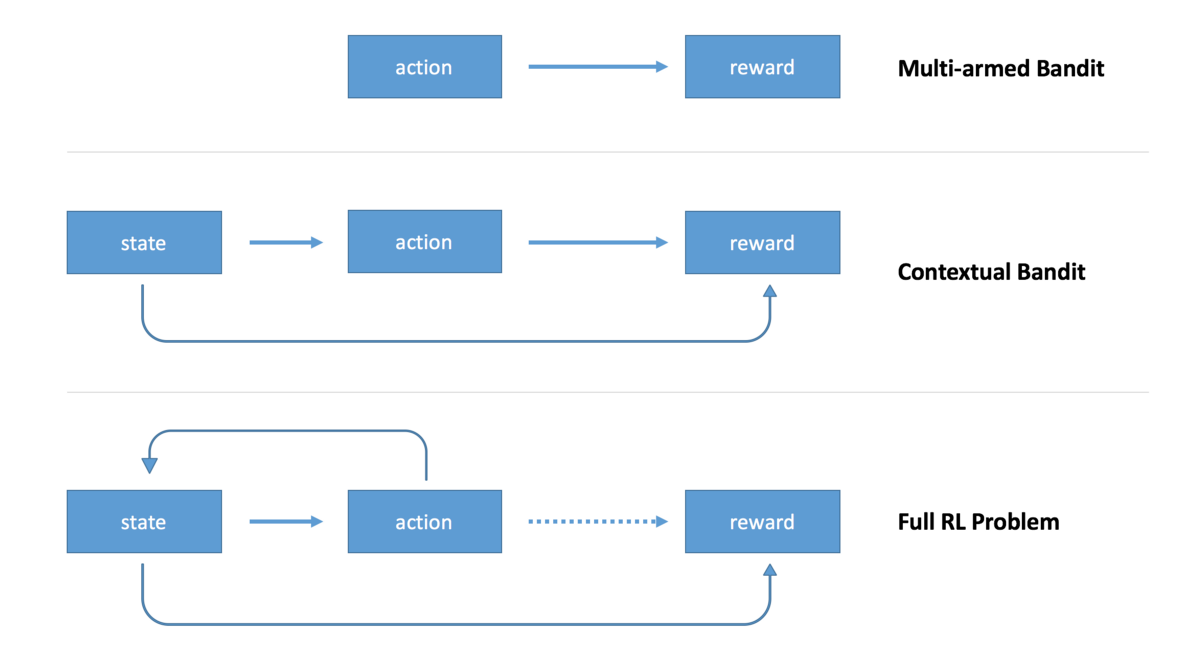
- Above: Multi-armed bandit problem, where only action effect reward.
- Middle: Contextual bandit problem, where state and action effect reward.
- Bottom: Full RL problem, where action effects state, and rewards may be delayed in time.


### Contextual bandit

In the original multi-armed bandit problem there is only a single bandit, which can be thought of as like a slot-machine. The range of actions available to the agent consist of pulling one of multiple arms of the bandit. By doing so, a reward of +1 or -1 is received at different rates. The problem is considered solved if the agent learns to always choose the arm that most often provides a positive reward.

In such a case, we can design an agent that completely ignores the state of the environment, since for all intents and purposes, there is only ever a single, unchanging state.

Contextual Bandits introduce the concept of the state. The state consists of a description of the environment that the agent can use to take more informed actions.

In our problem, instead of a single bandit, there can now be multiple bandits. The state of the environment tells us which bandit we are dealing with, and the goal of the agent is to learn the best action not just for a single bandit, but for any number of them.

Since each bandit will have different reward probabilities for each arm, our agent will need to learn to condition its action on the state of the environment. Unless it does this, it won’t achieve the maximum reward possible over time.

In order to accomplish this, we will be building a single-layer neural network in Tensorflow that takes a state and produces an action. By using a policy-gradient update method, we can have the network learn to take actions that maximize its reward.

### One-hot encoding

https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science
One hot encoding transforms categorical features to a format that works better with classification and regression algorithms.

Let’s take the following example. I have seven sample inputs of categorical data belonging to four categories. Now, I could encode these to nominal values as I have done here, but that wouldn’t make sense from a machine learning perspective. We can’t say that the category of “Penguin” is greater or smaller than “Human”. Then they would be ordinal values, not nominal.

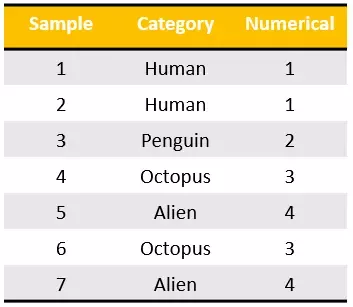

What we do instead is generate one boolean column for each category. Only one of these columns could take on the value 1 for each sample. Hence, the term one hot encoding.
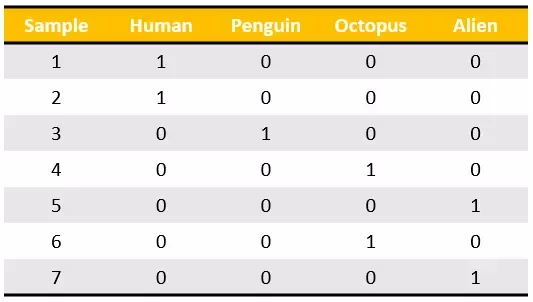

This works very well with most machine learning algorithms. Some algorithms, like random forests, handle categorical values natively. Then, one hot encoding is not necessary. The process of one hot encoding may seem tedious, but fortunately, most modern machine learning libraries can take care of it.

## Code

### Setup

In [17]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np

### Contextual Bandits
Here we define our contextual bandits. In this example, we are using three four-armed bandit. What this means is that each bandit has four arms that can be pulled. Each bandit has different success probabilities for each arm, and as such requires different actions to obtain the best result. The pullBandit function generates a random number from a normal distribution with a mean of 0. The lower the bandit number, the more likely a positive reward will be returned. We want our agent to learn to always choose the bandit-arm that will most often give a positive reward, depending on the Bandit presented.


In [18]:
class contextual_bandit(object):
    def __init__(self):
        self.state = 0
        #List out our bandits. Currently arms 4, 2, and 1 (respectively) are the most optimal.
        self.bandits = np.array([[0.2,0,-0.0,-5],
                                 [0.1,-5,1,0.25],
                                 [-5,5,5,5]])
        self.num_bandits = self.bandits.shape[0]
        self.num_actions = self.bandits.shape[1]
        
    def getBandit(self):
        '''Returns a random state for each episode.'''
        self.state = np.random.randint(0, len(self.bandits))
        return self.state
        
    def pullArm(self,action):
        #Get a random number.
        bandit = self.bandits[self.state, action]
        result = np.random.randn(1)
        if result > bandit:
            #return a positive reward.
            return 1
        else:
            #return a negative reward.
            return -1

### The Policy-Based Agent
The code below established our simple neural agent. It takes as input the current state, and returns an action. 

This allows the agent to take actions which are conditioned on the state of the environment, a critical step toward being able to solve full RL problems. The agent uses a single set of weights, within which each value is an estimate of the value of the return from choosing a particular arm given a bandit.

We use a policy gradient method to update the agent by moving the value for the selected action toward the recieved reward.

In [19]:
help(slim.one_hot_encoding)

Help on function one_hot_encoding in module tensorflow.contrib.layers.python.layers.layers:

one_hot_encoding(labels, num_classes, on_value=1.0, off_value=0.0, outputs_collections=None, scope=None)
    Transform numeric labels into onehot_labels using `tf.one_hot`.
    
    Args:
      labels: [batch_size] target labels.
      num_classes: Total number of classes.
      on_value: A scalar defining the on-value.
      off_value: A scalar defining the off-value.
      outputs_collections: Collection to add the outputs.
      scope: Optional scope for name_scope.
    
    Returns:
      One-hot encoding of the labels.



In [20]:
help(slim.fully_connected)

Help on function fully_connected in module tensorflow.contrib.layers.python.layers.layers:

fully_connected(inputs, num_outputs, activation_fn=<function relu at 0x7f2d115ae8c8>, normalizer_fn=None, normalizer_params=None, weights_initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f2cfb94c158>, weights_regularizer=None, biases_initializer=<tensorflow.python.ops.init_ops.Zeros object at 0x7f2cfb9c5c18>, biases_regularizer=None, reuse=None, variables_collections=None, outputs_collections=None, trainable=True, scope=None)
    Adds a fully connected layer.
    
    `fully_connected` creates a variable called `weights`, representing a fully
    connected weight matrix, which is multiplied by the `inputs` to produce a
    `Tensor` of hidden units. If a `normalizer_fn` is provided (such as
    `batch_norm`), it is then applied. Otherwise, if `normalizer_fn` is
    None and a `biases_initializer` is provided then a `biases` variable would be
    created and added the

In [21]:
class agent(object):
    def __init__(self, lr, s_size, a_size):
        # These lines established the feed-forward part of the network.
        # The agent takes a state and produces an action.
        self.state_in = tf.placeholder(shape=[1], dtype=tf.int32, name="state-input")
        state_in_OH = slim.one_hot_encoding(self.state_in, s_size)
        output = slim.fully_connected(state_in_OH, a_size,
                                      biases_initializer=None,
                                      activation_fn=tf.nn.sigmoid,
                                      weights_initializer=tf.ones_initializer())
        self.output = tf.reshape(output, [-1])
        self.chosen_action = tf.argmax(self.output, 0)

        # The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        # to compute the loss, and use it to update the network.
        self.reward_holder = tf.placeholder(shape=[1], dtype=tf.float32, name="reward")
        self.action_holder = tf.placeholder(shape=[1], dtype=tf.int32, name="action")
        self.responsible_weight = tf.slice(self.output, self.action_holder, [1])
        self.loss = -(tf.log(self.responsible_weight) * self.reward_holder)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr, name="loss-optimizer")
        self.update = optimizer.minimize(self.loss)

In [22]:
tf.reset_default_graph() #Clear the Tensorflow graph.

cBandit = contextual_bandit() #Load the bandits.
myAgent = agent(lr=0.001,s_size=cBandit.num_bandits,a_size=cBandit.num_actions) #Load the agent.

print("Variables that will be trained:", tf.trainable_variables()[0])
show_graph(tf.get_default_graph())

Variables that will be trained: <tf.Variable 'fully_connected/weights:0' shape=(3, 4) dtype=float32_ref>


### Training

In [23]:
total_episodes = 10000 # Set total number of episodes to train agent on.
total_reward = np.zeros([cBandit.num_bandits,
                         cBandit.num_actions]) #Set scoreboard for bandits to 0.

e = 0.1 # Set the chance of taking a random action.

init = tf.initialize_all_variables()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        s = cBandit.getBandit() # Get a state from the environment.
        
        # Choose either a random action or one from our network.
        if np.random.rand(1) < e:
            action = np.random.randint(cBandit.num_actions)
        else:
            action = sess.run(myAgent.chosen_action,feed_dict={myAgent.state_in:[s]})
        
        reward = cBandit.pullArm(action) # Get our reward for taking an action given a bandit.
        
         #Update the network.
        feed_dict={myAgent.reward_holder: [reward],
                   myAgent.action_holder: [action],
                   myAgent.state_in:    [s]}
        _,ww = sess.run([myAgent.update,weights], feed_dict=feed_dict)
        
        #Update our running tally of scores.
        total_reward[s,action] += reward
        if i % 500 == 0:
            print("Mean reward for each of the " + str(cBandit.num_bandits) + " bandits: " + str(np.mean(total_reward,axis=1)))
        i+=1

for a in range(cBandit.num_bandits):
    print("The agent thinks action " + str(np.argmax(ww[a])+1) + " for bandit " + str(a+1) + " is the most promising....")
    if np.argmax(ww[a]) == np.argmin(cBandit.bandits[a]):
        print("...and it was right!")
    else:
        print("...and it was wrong!")


Instructions for updating:
Use `tf.global_variables_initializer` instead.


ValueError: Fetch argument <tf.Variable 'bandit-weights:0' shape=(4,) dtype=float32_ref> cannot be interpreted as a Tensor. (Tensor Tensor("bandit-weights:0", shape=(4,), dtype=float32_ref) is not an element of this graph.)

# Simple Reinforcement Learning with Tensorflow: Part 2 - Policy-based Agents

![image.png](https://cdn-images-1.medium.com/max/1200/1*G_whtIrY9fGlw3It6HFfhA.gif)

## Notes

### MDPs

Environments which pose the full problem to an agent are referred to as Markov Decision Processes (MDPs). These environments not only provide rewards and state transitions given actions, but those rewards are also condition on the state of the environment and the action the agent takes within that state. These dynamics are also temporal, and can be delayed over time.